# Problema 2 

Considere el conjunto de datos de fraudes realizados con tarjeta de creito en el siguiente link. 
Utilizando los metodos vistos en clase, encuentre el mejor modelo de clasificacion para el caso 
en estudio, si una transaccion es fraudulenta o no. Considere: 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score
from scipy.stats import zscore
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('card_transdata.csv')

## Eliminación de información redundante 


Revsión de existencia de campos null en el archivo y tipo de datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


Identificar datos duplicados

In [4]:
filas_duplicadas = df.duplicated()
print("Filas Duplicadas:")
print(len(df[filas_duplicadas]))

Filas Duplicadas:
0


In [5]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [6]:
df.fraud.value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

Busqueda de datos atipicos

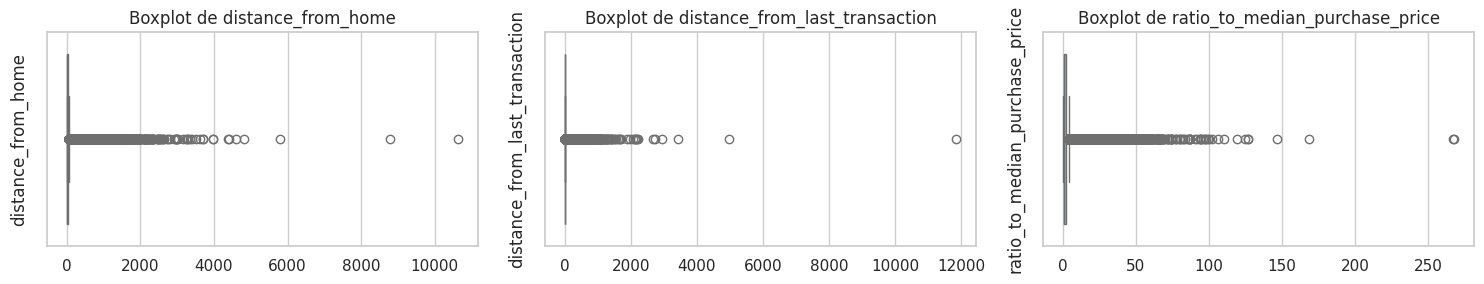

1000000


In [7]:
columnas_numericas = df.iloc[:, :3]
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
for i, columna in enumerate(columnas_numericas.columns):
    sns.boxplot(x=columnas_numericas[columna], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot de {columna}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(columna)

plt.tight_layout()
plt.show()
print(len(df))

Eliminación de datos atipicos definiendo un umbral z=3 lo que representa bajo el supuesto de distirbución normal estándar el 99.7% de los datos

In [8]:
umbral_zscore = 3
z_scores = zscore(df.select_dtypes(include=['float64', 'int64']))
filas_outliers = (abs(z_scores) > umbral_zscore).any(axis=1)

# Eliminar filas con outliers
dataframe_sin_outliers = df[~filas_outliers]

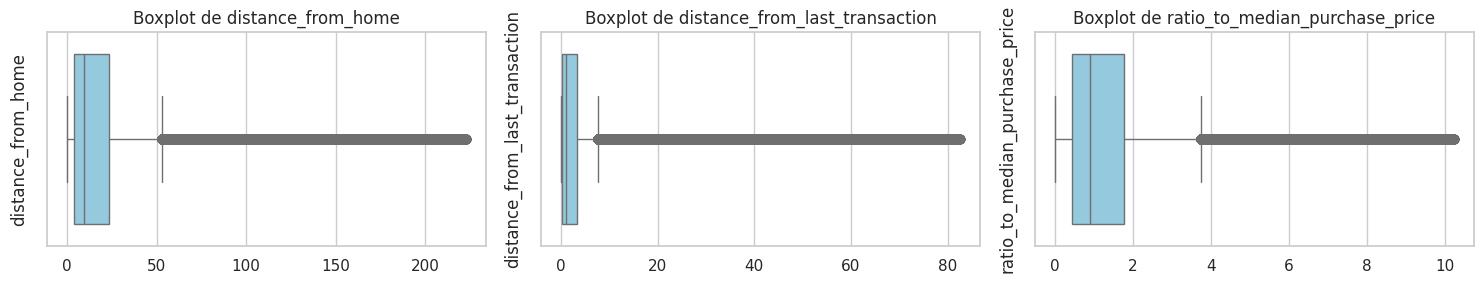

895305
queda el 0.895305 de los datos


In [9]:
columnas_numericas = dataframe_sin_outliers.iloc[:, :3]
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
for i, columna in enumerate(columnas_numericas.columns):
    sns.boxplot(x=columnas_numericas[columna], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot de {columna}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(columna)

plt.tight_layout()
plt.show()
print(len(dataframe_sin_outliers))
pIQR = len(dataframe_sin_outliers) / len(df)
print(f"queda el {pIQR} de los datos")

In [10]:
dataframe_sin_outliers.fraud.value_counts()

0.0    895305
Name: fraud, dtype: int64

Eliminación de datos atipicos por IQR que es más robusto frente a distribuciones no normales

In [11]:
columnas_numericas = df.iloc[:, :3]

# Calcular el rango intercuartílico (IQR) para cada columna
Q1 = columnas_numericas.quantile(0.25)
Q3 = columnas_numericas.quantile(0.75)
IQR = Q3 - Q1

# Definir un umbral para identificar outliers basados en IQR
umbral_IQR = 1.5

# Identificar filas con outliers
mascara_outliers = ((columnas_numericas < (Q1 - umbral_IQR * IQR)) | (columnas_numericas > (Q3 + umbral_IQR * IQR))).any(axis=1)

# Eliminar filas con outliers
dataframe_sin_outliers_IQR = df[~mascara_outliers]

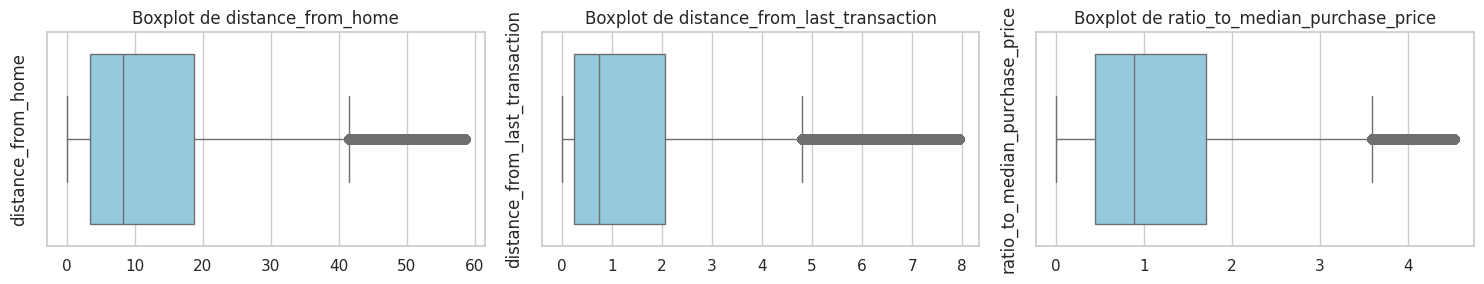

718750
queda el 0.71875 de los datos


In [12]:
columnas_numericas_IQR = dataframe_sin_outliers_IQR.iloc[:, :3]
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
for i, columna in enumerate(columnas_numericas_IQR.columns):
    sns.boxplot(x=columnas_numericas_IQR[columna], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot de {columna}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(columna)

plt.tight_layout()
plt.show()
print(len(dataframe_sin_outliers_IQR))
pIQR = len(dataframe_sin_outliers_IQR) / len(df)
print(f"queda el {pIQR} de los datos")

In [13]:
dataframe_sin_outliers_IQR.fraud.value_counts()

0.0    709710
1.0      9040
Name: fraud, dtype: int64

Al quitar los outliers se agudiza el desbalanceo de clases por lo que se decide trabajar la data original

## Selección de variables 



Estandarizamos la data sin atipicos

In [14]:
# Selecciona las primeras tres columnas que deseas estandarizar
columnas_a_estandarizar = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

# Crea el objeto StandardScaler
scaler = StandardScaler()

# Aplica el escalado a las primeras tres columnas y almacena los resultados en un nuevo DataFrame
df1 = pd.DataFrame(scaler.fit_transform(df[columnas_a_estandarizar]), columns=columnas_a_estandarizar)

# Selecciona las columnas restantes del DataFrame original
columnas_restantes =  ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']
df2 = df[columnas_restantes]

# Asegúrate de que los índices estén alineados
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

# Combina los dos DataFrames
df_estandarizado = pd.concat([df1, df2], axis=1)


Validamos datos luego de la estandarización

In [15]:
df_estandarizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [16]:
# Ajustar un modelo de regresión lineal entre dos de los índices

X = df_estandarizado[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']]
X = sm.add_constant(X)
y = df_estandarizado['fraud']

# Divide el conjunto de datos estandarizado en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Metrica de desempeño

In [17]:
def evaluate_model_performance(model, X_test, y_test, threshold=0.5):
    # Realiza predicciones en el conjunto de prueba
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    return cm, f1, acc, recall

Corremos el modelo base: Regresión logistica

In [18]:
model_base = sm.Logit(y_train, X_train)
results_base = model_base.fit()
# Imprime el resumen del modelo
print(results_base.summary())

# Llamada a la función con el modelo entrenado y el conjunto de prueba
#conf_matrix, f1score = evaluate_model_performance(results_base, X_test, y_test)
conf_matrix_base, f1score_base, accuracy_base, recall_base = evaluate_model_performance(results_base, X_test, y_test)

# Imprime la matriz de confusión, el F1-score y la precisión
print("Matriz de Confusión:")
print(conf_matrix_base)
print("\nF1-score:", f1score_base)
print("\nAccuracy:", accuracy_base)
print("\nRecall:", recall_base)


Optimization terminated successfully.
         Current function value: 0.136206
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:               800000
Model:                          Logit   Df Residuals:                   799992
Method:                           MLE   Df Model:                            7
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:                  0.5406
Time:                        20:18:22   Log-Likelihood:            -1.0896e+05
converged:                       True   LL-Null:                   -2.3719e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -8.2080      0.044   -185.975    

Aplicamos Lasso para identificar los betas insignificantes y corremos nuevamente el modelo

In [19]:
parameters = {'alpha': np.arange(0.001,5,0.5)}

lasso = Lasso()  # Use the Lasso model

clf = GridSearchCV(lasso, parameters)  # Initialize GridSearchCV with the Lasso model and alpha values
clf.fit(X_train, y_train)  # Fit the model

best_alpha = clf.best_params_

alpha_value = best_alpha['alpha']

print("Best alpha:", clf.best_params_) 

Best alpha: {'alpha': 0.001}


In [20]:
df_estandarizado.corr()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,0.000193,-0.001374,0.143124,-0.000697,-0.001622,-0.001301,0.187571
distance_from_last_transaction,0.000193,1.000000,0.001013,-0.000928,0.002055,-0.000899,0.000141,0.091917
ratio_to_median_purchase_price,-0.001374,0.001013,1.000000,0.001374,0.000587,0.000942,-0.000330,0.462305
repeat_retailer,0.143124,-0.000928,0.001374,1.000000,-0.001345,-0.000417,-0.000532,-0.001357
used_chip,-0.000697,0.002055,0.000587,-0.001345,1.000000,-0.001393,-0.000219,-0.060975
used_pin_number,-0.001622,-0.000899,0.000942,-0.000417,-0.001393,1.000000,-0.000291,-0.100293
online_order,-0.001301,0.000141,-0.000330,-0.000532,-0.000219,-0.000291,1.000000,0.191973
fraud,0.187571,0.091917,0.462305,-0.001357,-0.060975,-0.100293,0.191973,1.000000


La aplicación de Lasso no es significativa puesto, queda demostrado que todas las varibales son estadisticamente significativas y adicional no hay multicolinealidad con las variables.

In [21]:
# Aplica Lasso
alpha = alpha_value  # Puedes ajustar este valor según sea necesario
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

# Imprime los coeficientes seleccionados por Lasso
selected_features = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})
print(selected_features)

# Define un umbral para considerar los coeficientes como cero
threshold = 0.001  # Puedes ajustar este valor según sea necesario

# Selecciona solo las variables con coeficientes mayores que el umbral
selected_columns = selected_features[abs(selected_features['Coefficient']) > threshold]['Feature']

# Convierte el índice 'selected_columns' a una lista de nombres de columnas
selected_columns_list = selected_columns.tolist()

# Filtra el DataFrame original para incluir solo las variables seleccionadas
df_selected = X_train[selected_columns_list]

# Ajusta el modelo de regresión logística con las variables seleccionadas
X_selected_lasso = df_selected
X_selected_lasso = sm.add_constant(X_selected_lasso)

model_lasso = sm.Logit(y_train, X_selected_lasso)
results_lasso = model_lasso.fit()

X_test_lasso = X_test[selected_columns_list]
X_test_lasso = sm.add_constant(X_test_lasso)

# Imprime el resumen del modelo
print(results_lasso.summary())

conf_matrix_lasso, f1score_lasso, accuracy_lasso, recall_lasso = evaluate_model_performance(results_lasso, X_test_lasso, y_test)
print("Matriz de Confusión:")
print(conf_matrix_lasso)
print("\nF1-score:", f1score_lasso)
print("\nAccuracy:", accuracy_lasso)
print("\nRecall:", recall_lasso)

                          Feature  Coefficient
0                           const     0.000000
1              distance_from_home     0.052542
2  distance_from_last_transaction     0.023574
3  ratio_to_median_purchase_price     0.127861
4                 repeat_retailer    -0.015338
5                       used_chip    -0.032092
6                 used_pin_number    -0.083728
7                    online_order     0.109338
Optimization terminated successfully.
         Current function value: 0.136206
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:               800000
Model:                          Logit   Df Residuals:                   799992
Method:                           MLE   Df Model:                            7
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:                  0.5406
Time:                        20:18:29   Log-Likelihood:            -1.0896e+05


In [22]:

#def evaluate_features(features, X_train, X_test, y_train, y_test):
#    model = LogisticRegression()
#    model.fit(X_train[features], y_train)
#    y_pred = model.predict(X_test[features])
#    return accuracy_score(y_test, y_pred)

# Forward Selection
def forward_selection(X_train, X_test, y_train, y_test, features):
    sfs = SequentialFeatureSelector(LogisticRegression(), direction='forward', scoring='f1', cv=None)
    sfs.fit(X_train, y_train)
    selected_features = list(X_train.columns[sfs.get_support()])
    return selected_features

# Backward Selection
def backward_selection(X_train, X_test, y_train, y_test, features):
    sbs = SequentialFeatureSelector(LogisticRegression(), direction='backward', scoring='f1', cv=None)
    sbs.fit(X_train, y_train)
    selected_features = list(X_train.columns[sbs.get_support()])
    return selected_features

# Aplica forward selection y backward selection a tus datos
all_features = list(df.columns[:-1])  # Todas las características excepto 'fraud'

forward selection

In [23]:
# Aplica forward selection
selected_features_forward = forward_selection(X_train, X_test, y_train, y_test, all_features)
print("Forward Selection Result:", selected_features_forward)

Forward Selection Result: ['distance_from_home', 'ratio_to_median_purchase_price', 'used_pin_number', 'online_order']


In [24]:

# Filtra el DataFrame original para incluir solo las variables seleccionadas
df_selected_forward = X_train[selected_features_forward]

# Ajusta el modelo de regresión logística con las variables seleccionadas
X_selected_forward = df_selected_forward

model_forward = sm.Logit(y_train, X_selected_forward)
results_forward = model_forward.fit()

X_test_forward = X_test[selected_features_forward]

# Imprime el resumen del modelo
print(results_forward.summary())

conf_matrix_RL_forward, f1score_RL_forward, accuracy_RL_forward, recall_RL_forward = evaluate_model_performance(results_forward, X_test_forward, y_test)
print("Matriz de Confusión:")
print(conf_matrix_RL_forward)
print("\nF1-score:", f1score_RL_forward)
print("\nAccuracy:", accuracy_RL_forward)
print("\nRecall:", recall_RL_forward)


Optimization terminated successfully.
         Current function value: 0.379461
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:               800000
Model:                          Logit   Df Residuals:                   799996
Method:                           MLE   Df Model:                            3
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:                 -0.2799
Time:                        20:19:25   Log-Likelihood:            -3.0357e+05
converged:                       True   LL-Null:                   -2.3719e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
distance_from_home                 0.4982      0.004    122.009    

backward selection

In [25]:
# Aplica backward selection
selected_features_backward = backward_selection(X_train, X_test, y_train, y_test, all_features)
print("Backward Selection Result:", selected_features_backward)


Backward Selection Result: ['distance_from_home', 'ratio_to_median_purchase_price', 'used_pin_number', 'online_order']


In [26]:
# Filtra el DataFrame original para incluir solo las variables seleccionadas
df_selected_backward = X_train[selected_features_backward]

# Ajusta el modelo de regresión logística con las variables seleccionadas
X_selected_backward = df_selected_backward

model_backward = sm.Logit(y_train, X_selected_backward)
results_backward = model_backward.fit()

X_test_backward = X_test[selected_features_backward]

# Imprime el resumen del modelo
print(results_backward.summary())

conf_matrix_backward, f1score_backward, accuracy_backward, recall_backward = evaluate_model_performance(results_backward, X_test_forward, y_test)
print("Matriz de Confusión:")
print(conf_matrix_backward)
print("\nF1-score:", f1score_backward)
print("\nAccuracy:", accuracy_backward)
print("\nRecall:", recall_backward)


Optimization terminated successfully.
         Current function value: 0.379461
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:               800000
Model:                          Logit   Df Residuals:                   799996
Method:                           MLE   Df Model:                            3
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:                 -0.2799
Time:                        20:21:03   Log-Likelihood:            -3.0357e+05
converged:                       True   LL-Null:                   -2.3719e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
distance_from_home                 0.4982      0.004    122.009    

## Selección de una métrica adecuada 

Se considera que para este caso es más importante identificar los errores de tipo 2 (FN) clasificar incorrectamente casos positivos como negativos, por tal motivo se decide utlizar la metrica de F1-score y recall para la seleccion del mejor modelo.

In [27]:
results = pd.DataFrame({
    'Modelo': ['Base', 'Lasso', 'Forward', 'Backward'],
    'Matriz de Confusión TP-FP-FN-TN': [conf_matrix_base, conf_matrix_lasso, conf_matrix_RL_forward, conf_matrix_backward],
    'F1-score': [f1score_base, f1score_lasso, f1score_RL_forward, f1score_backward],
    'Accuracy': [accuracy_base, accuracy_lasso, accuracy_RL_forward, accuracy_backward],
    'Recall': [recall_base, recall_lasso, recall_RL_forward, recall_backward]
})

results

,Modelo,Matriz de Confusión TP-FP-FN-TN,F1-score,Accuracy,Recall
0,Base,"[[181295, 1224], [6892, 10589]]",0.722947,0.959420,0.605743
1,Lasso,"[[181295, 1224], [6892, 10589]]",0.722947,0.959420,0.605743
2,Forward,"[[163889, 18630], [10431, 7050]]",0.326684,0.854695,0.403295
3,Backward,"[[163889, 18630], [10431, 7050]]",0.326684,0.854695,0.403295


Por lo anterior se decide trabajar con todas las variables puesto queda demostrado que son estadisticamente significativas.

## Definición  de  métricas  de  un  modelo  baseline  (clasificador  aleatorio)  como  punto  de referencia 

Modelo base regresión logistica

In [28]:
X = df_estandarizado[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']]
X = sm.add_constant(X)
y = df_estandarizado['fraud']

# Divide el conjunto de datos estandarizado en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


results = pd.DataFrame({
    'Modelo': ['RL'],
    'Matriz de Confusión TP-FP-FN-TN': [conf_matrix_base],
    'F1-score': [f1score_base],
    'Accuracy': [accuracy_base],
    'Recall': [recall_base]
})

results

,Modelo,Matriz de Confusión TP-FP-FN-TN,F1-score,Accuracy,Recall
0,RL,"[[181295, 1224], [6892, 10589]]",0.722947,0.95942,0.605743


KNN

In [29]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)

# Evalúa el modelo en el conjunto de prueba
conf_matrix_knn, f1score_knn, accuracy_knn, recall_knn = evaluate_model_performance(knn_model, X_test, y_test)
print("Matriz de Confusión:")
print(conf_matrix_knn)
print("\nF1-score:", f1score_knn)
print("\nAccuracy:", accuracy_knn)
print("\nRecall:", recall_knn)

Matriz de Confusión:
[[182476     43]
 [   250  17231]]

F1-score: 0.99156955833693

Accuracy: 0.998535

Recall: 0.985698758652251


LDA

Matriz de Confusión:
[[180349   2170]
 [ 10810   6671]]

F1-score: 0.5068763771749867

Accuracy: 0.9351

Recall: 0.3816143241233339


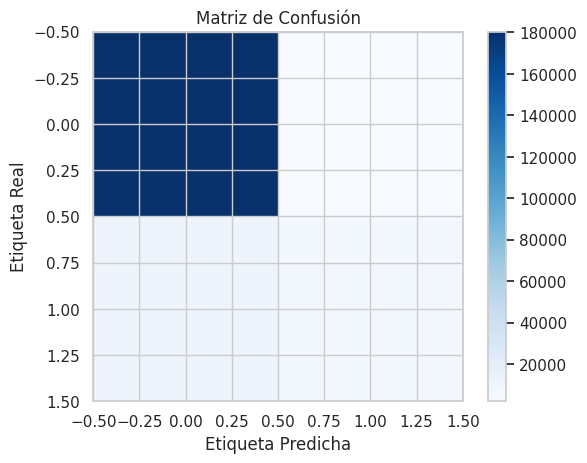

In [30]:
# Crea y entrena el modelo LDA
lda_model = LinearDiscriminantAnalysis()
result_lda = lda_model.fit(X_train, y_train)

conf_matrix_lda, f1score_lda, accuracy_lda, recall_lda = evaluate_model_performance(result_lda, X_test, y_test)

print("Matriz de Confusión:")
print(conf_matrix_lda)
print("\nF1-score:", f1score_lda)
print("\nAccuracy:", accuracy_lda)
print("\nRecall:", recall_lda)

# Grafica la matriz de confusión
plt.imshow(conf_matrix_lda, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()


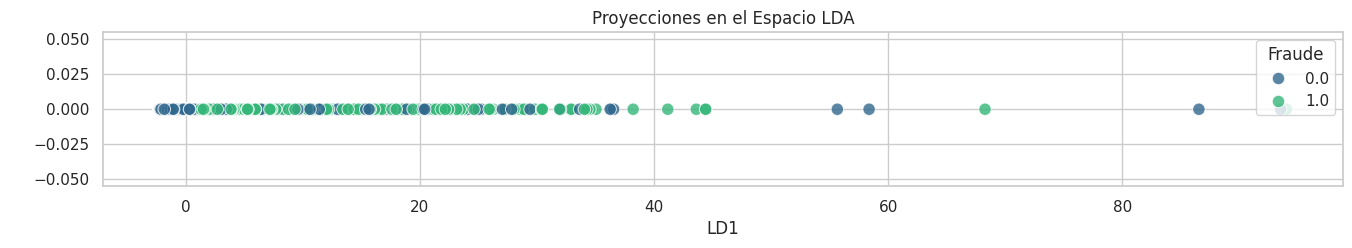

In [31]:
# Crea y entrena el modelo LDA
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# Transforma los datos de entrenamiento al espacio LDA
X_lda_train = lda_model.transform(X_train)

# Crea un DataFrame con las proyecciones y la etiqueta de clase
df_lda_train = pd.DataFrame(X_lda_train, columns=['LD1'])
df_lda_train['fraud'] = y_train.values

# Grafica las proyecciones en el espacio LDA
plt.figure(figsize=(16, 2))
sns.scatterplot(x='LD1', y=0, hue='fraud', data=df_lda_train, palette='viridis', s=80, alpha=0.8)
plt.title('Proyecciones en el Espacio LDA')
plt.xlabel('LD1')
plt.ylabel(' ')
plt.legend(title='Fraude', loc='upper right')
plt.show()

QDA

/home/camilo/.local/share/virtualenvs/Taller2_Estadistica-VjdUl4YZ/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/camilo/.local/share/virtualenvs/Taller2_Estadistica-VjdUl4YZ/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:960: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/camilo/.local/share/virtualenvs/Taller2_Estadistica-VjdUl4YZ/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:960: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/camilo/.local/share/virtualenvs/Taller2_Estadistica-VjdUl4YZ/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:963: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


Matriz de Confusión:
[[182519      0]
 [ 17481      0]]

F1-score: 0.0

Accuracy: 0.912595

Recall: 0.0


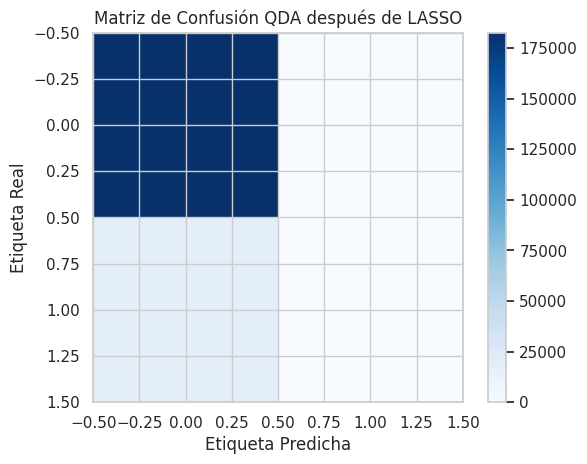

In [32]:
# Crea y entrena el modelo QDA
qda_model = QuadraticDiscriminantAnalysis()
result_qda = qda_model.fit(X_train, y_train)

conf_matrix_qda, f1score_qda, accuracy_qda, recall_qda = evaluate_model_performance(result_qda, X_test, y_test)

print("Matriz de Confusión:")
print(conf_matrix_qda)
print("\nF1-score:", f1score_qda)
print("\nAccuracy:", accuracy_qda)
print("\nRecall:", recall_qda)

# Grafica la matriz de confusión
plt.imshow(conf_matrix_qda, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión QDA después de LASSO')
plt.colorbar()
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

Naive Bayes

Matriz de Confusión:
[[179804   2715]
 [  7132  10349]]

F1-score: 0.6776231789163529

Accuracy: 0.950765

Recall: 0.5920141868314169


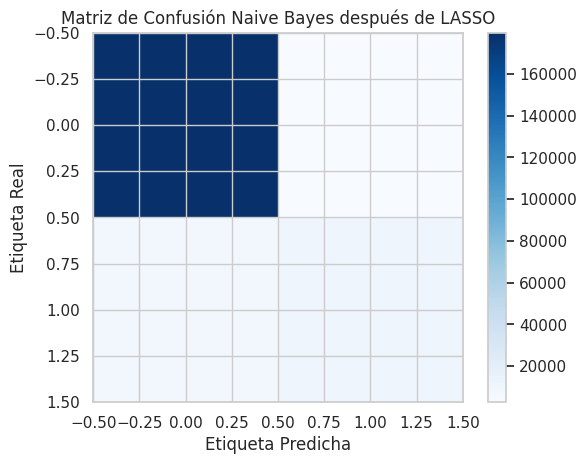

In [33]:
# Crea y entrena el modelo Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred_nb = nb_model.predict(X_test)

# Calcula la matriz de confusión y otras métricas de desempeño
conf_matrix_nb, f1score_nb, accuracy_nb, recall_nb = evaluate_model_performance(nb_model, X_test, y_test)

# Imprime la matriz de confusión y las métricas de desempeño
print("Matriz de Confusión:")
print(conf_matrix_nb)
print("\nF1-score:", f1score_nb)
print("\nAccuracy:", accuracy_nb)
print("\nRecall:", recall_nb)

# Grafica la matriz de confusión
plt.imshow(conf_matrix_nb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión Naive Bayes después de LASSO')
plt.colorbar()
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

## Entrenamiento, validación y prueba para los modelos 

Se resume la validación de los modelos en la siguiente tabla, por el momento, el que mejor metrícas presenta es el KNN con k=4, sin embargo LDA presenta un mejor recall a cambio de cometer más errores tipo 1 (FP), es decir predecir un fraude cuando no está presente.

In [34]:
results_models = pd.DataFrame({
    'Modelo': ['RL','KNN','LDA','QDA','Naive Bayes'],
    'Matriz de Confusión TP-FP-FN-TN': [conf_matrix_base, conf_matrix_knn, conf_matrix_lda, conf_matrix_qda, conf_matrix_nb],
    'F1-score': [f1score_base, f1score_knn, f1score_lda, f1score_qda, f1score_nb],
    'Accuracy': [accuracy_base, accuracy_knn, accuracy_lda, accuracy_qda, accuracy_nb],
    'Recall': [recall_base, recall_knn, recall_lda, recall_qda, recall_nb]
})

results_models

,Modelo,Matriz de Confusión TP-FP-FN-TN,F1-score,Accuracy,Recall
0,RL,"[[181295, 1224], [6892, 10589]]",0.722947,0.959420,0.605743
1,KNN,"[[182476, 43], [250, 17231]]",0.991570,0.998535,0.985699
2,LDA,"[[180349, 2170], [10810, 6671]]",0.506876,0.935100,0.381614
3,QDA,"[[182519, 0], [17481, 0]]",0.000000,0.912595,0.000000
4,Naive Bayes,"[[179804, 2715], [7132, 10349]]",0.677623,0.950765,0.592014


## Ajuste de hiperparémetros para cada uno de los modelos 

KNN - se ajustó con un K=3 el cual demostró el mejor desempeño.

In [35]:
results_list = []

for n_neighbors in range(1,12):#n_neighbors_values:
    # Crea y entrena el modelo k-NN
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)

    # Evalúa el modelo en el conjunto de prueba
    conf_matrix_knn, f1score_knn, accuracy_knn, recall_knn = evaluate_model_performance(knn_model, X_test, y_test)

    # Almacena los resultados en un diccionario
    results_list.append({
        'n_neighbors': n_neighbors,
        'conf_matrix': conf_matrix_knn,
        'f1score': f1score_knn,
        'accuracy': accuracy_knn,
        'recall': recall_knn
    })

# Convierte la lista de resultados en un DataFrame
results_df_knn = pd.DataFrame(results_list)

# Imprime el DataFrame
results_df_knn


,n_neighbors,conf_matrix,f1score,accuracy,recall
0,1,"[[182390, 129], [131, 17350]]",0.992563,0.998700,0.992506
1,2,"[[182476, 43], [250, 17231]]",0.991570,0.998535,0.985699
2,3,"[[182408, 111], [134, 17347]]",0.992988,0.998775,0.992335
3,4,"[[182464, 55], [216, 17265]]",0.992213,0.998645,0.987644
4,5,"[[182411, 108], [143, 17338]]",0.992814,0.998745,0.991820
5,6,"[[182453, 66], [221, 17260]]",0.991755,0.998565,0.987358
6,7,"[[182410, 109], [148, 17333]]",0.992641,0.998715,0.991534
7,8,"[[182454, 65], [204, 17277]]",0.992275,0.998655,0.988330
8,9,"[[182413, 106], [150, 17331]]",0.992669,0.998720,0.991419
9,10,"[[182445, 74], [204, 17277]]",0.992019,0.998610,0.988330


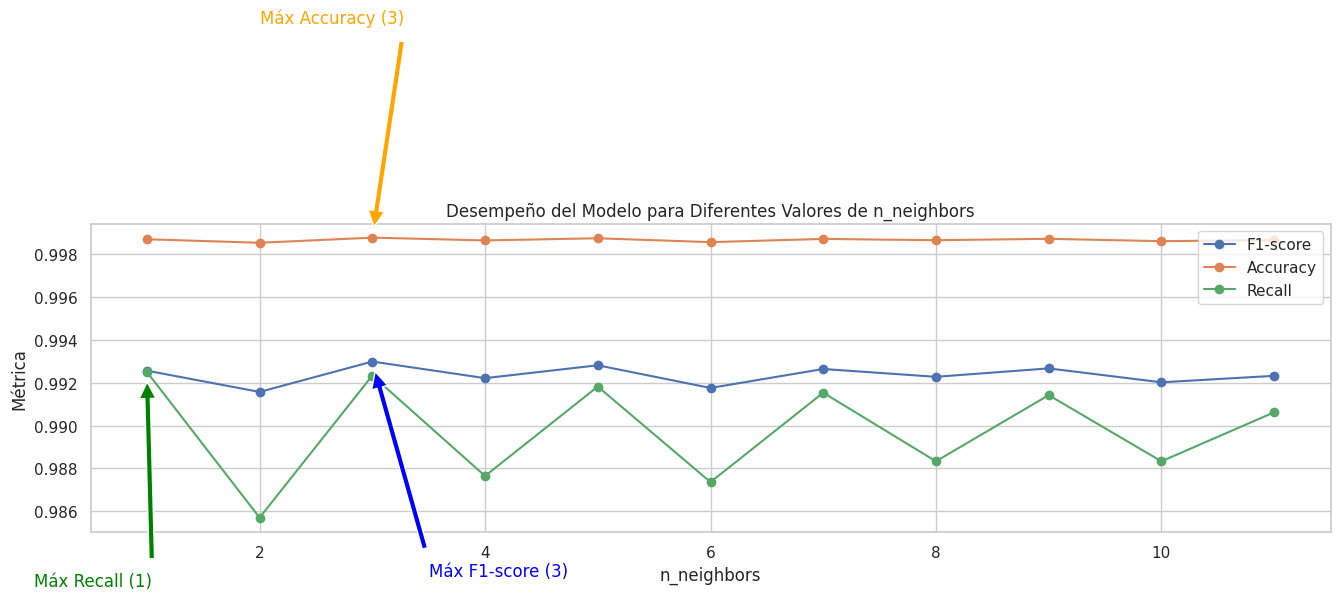

In [36]:
max_f1score_index = results_df_knn['f1score'].idxmax()
max_accuracy_index = results_df_knn['accuracy'].idxmax()
max_recall_index = results_df_knn['recall'].idxmax()

# Graficar F1-score, accuracy y recall en función de n_neighbors
plt.figure(figsize=(16, 4))

plt.plot(results_df_knn['n_neighbors'], results_df_knn['f1score'], label='F1-score', marker='o')
plt.plot(results_df_knn['n_neighbors'], results_df_knn['accuracy'], label='Accuracy', marker='o')
plt.plot(results_df_knn['n_neighbors'], results_df_knn['recall'], label='Recall', marker='o')

# Resaltar el punto máximo de cada métrica
plt.annotate(f'Máx F1-score ({results_df_knn["n_neighbors"][max_f1score_index]})', 
             xy=(results_df_knn['n_neighbors'][max_f1score_index], results_df_knn['f1score'][max_f1score_index]),
             xytext=(results_df_knn['n_neighbors'][max_f1score_index] + 0.5, results_df_knn['f1score'][max_f1score_index] - 0.01),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             color='blue')

plt.annotate(f'Máx Accuracy ({results_df_knn["n_neighbors"][max_accuracy_index]})', 
             xy=(results_df_knn['n_neighbors'][max_accuracy_index], results_df_knn['accuracy'][max_accuracy_index]),
             xytext=(results_df_knn['n_neighbors'][max_accuracy_index] - 1, results_df_knn['accuracy'][max_accuracy_index] + 0.01),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             color='orange')

plt.annotate(f'Máx Recall ({results_df_knn["n_neighbors"][max_recall_index]})', 
             xy=(results_df_knn['n_neighbors'][max_recall_index], results_df_knn['recall'][max_recall_index]),
             xytext=(results_df_knn['n_neighbors'][max_recall_index] - 1, results_df_knn['recall'][max_recall_index] - 0.01),
             arrowprops=dict(facecolor='green', shrink=0.05),
             color='green')

# Coloca la leyenda en la parte superior derecha
plt.legend(loc='upper right')

plt.title('Desempeño del Modelo para Diferentes Valores de n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Métrica')
plt.grid(True)
plt.show()


In [37]:
knn_model = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', metric='minkowski', metric_params=None, n_jobs=None)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

# Evalúa el modelo
conf_matrix = confusion_matrix(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

conf_matrix_knn_bestk, f1score_knn_bestk, accuracy_knn_bestk, recall_knn_bestk = evaluate_model_performance(knn_model, X_test, y_test)
print("Matriz de Confusión:")
print(conf_matrix_knn_bestk)
print("\nF1-score:", f1score_knn_bestk)
print("\nAccuracy:", accuracy_knn_bestk)
print("\nRecall:", recall_knn_bestk)

Matriz de Confusión:
[[182408    111]
 [   134  17347]]

F1-score: 0.9929877787000201

Accuracy: 0.998775

Recall: 0.9923345346376066


In [38]:
X_train_lasso = X_train[selected_columns_list]
X_train_lasso = sm.add_constant(X_train_lasso)
X_test_lasso = X_test[selected_columns_list]
X_test_lasso = sm.add_constant(X_test_lasso)

LDA - lasso

In [39]:
# Crea y entrena el modelo LDA
lda_model = LinearDiscriminantAnalysis(solver='lsqr')
result_lda = lda_model.fit(X_train_lasso, y_train)

conf_matrix_lda_lasso, f1score_lda_lasso, accuracy_lda_lasso, recall_lda_lasso = evaluate_model_performance(result_lda, X_test_lasso, y_test)

print("Matriz de Confusión:")
print(conf_matrix_lda_lasso)
print("\nF1-score:", f1score_lda_lasso)
print("\nAccuracy:", accuracy_lda_lasso)
print("\nRecall:", recall_lda_lasso)

Matriz de Confusión:
[[180349   2170]
 [ 10810   6671]]

F1-score: 0.5068763771749867

Accuracy: 0.9351

Recall: 0.3816143241233339


QDA - lasso

/home/camilo/.local/share/virtualenvs/Taller2_Estadistica-VjdUl4YZ/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/camilo/.local/share/virtualenvs/Taller2_Estadistica-VjdUl4YZ/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:960: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/camilo/.local/share/virtualenvs/Taller2_Estadistica-VjdUl4YZ/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:960: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/camilo/.local/share/virtualenvs/Taller2_Estadistica-VjdUl4YZ/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:963: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


Matriz de Confusión:
[[182519      0]
 [ 17481      0]]

F1-score: 0.0

Accuracy: 0.912595

Recall: 0.0


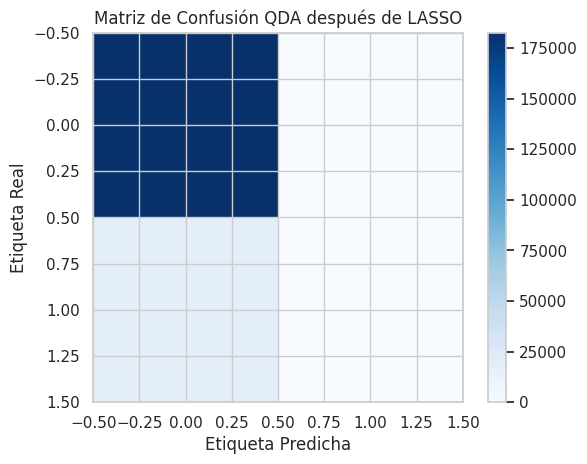

In [40]:
# Crea y entrena el modelo QDA
qda_model = QuadraticDiscriminantAnalysis()
result_qda = qda_model.fit(X_train_lasso, y_train)

conf_matrix_qda_lasso, f1score_qda_lasso, accuracy_qda_lasso, recall_qda_lasso = evaluate_model_performance(result_qda, X_test_lasso, y_test)

print("Matriz de Confusión:")
print(conf_matrix_qda)
print("\nF1-score:", f1score_qda)
print("\nAccuracy:", accuracy_qda)
print("\nRecall:", recall_qda)

# Grafica la matriz de confusión
plt.imshow(conf_matrix_qda, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión QDA después de LASSO')
plt.colorbar()
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

Naive Bayes - Lasso

In [41]:
# Crea y entrena el modelo Naive Bayes
nb_model = GaussianNB(priors=None, var_smoothing=1)
nb_model.fit(X_train_lasso, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred_nb = nb_model.predict(X_test_lasso)

# Calcula la matriz de confusión y otras métricas de desempeño
conf_matrix_nb_lasso, f1score_nb_lasso, accuracy_nb_lasso, recall_nb_lasso = evaluate_model_performance(nb_model, X_test_lasso, y_test)

# Imprime la matriz de confusión y las métricas de desempeño
print("Matriz de Confusión:")
print(conf_matrix_nb_lasso)
print("\nF1-score:", f1score_nb_lasso)
print("\nAccuracy:", accuracy_nb_lasso)
print("\nRecall:", recall_nb_lasso)

Matriz de Confusión:
[[180472   2047]
 [ 14767   2714]]

F1-score: 0.24404280190630342

Accuracy: 0.91593

Recall: 0.155254276071163


In [42]:
results_models = pd.DataFrame({
    'Modelo': ['RL','KNN','LDA','QDA','Naive Bayes'],
    'Matriz de Confusión TP-FP-FN-TN': [conf_matrix_base, conf_matrix_knn_bestk, conf_matrix_lda_lasso, conf_matrix_qda_lasso, conf_matrix_nb_lasso],
    'F1-score': [f1score_base, f1score_knn_bestk, f1score_lda_lasso, f1score_qda_lasso, f1score_nb_lasso],
    'Accuracy': [accuracy_base, accuracy_knn_bestk, accuracy_lda_lasso, accuracy_qda_lasso, accuracy_nb_lasso],
    'Recall': [recall_base, recall_knn_bestk, recall_lda_lasso, recall_qda_lasso, recall_nb_lasso]
})


results_models

,Modelo,Matriz de Confusión TP-FP-FN-TN,F1-score,Accuracy,Recall
0,RL,"[[181295, 1224], [6892, 10589]]",0.722947,0.959420,0.605743
1,KNN,"[[182408, 111], [134, 17347]]",0.992988,0.998775,0.992335
2,LDA,"[[180349, 2170], [10810, 6671]]",0.506876,0.935100,0.381614
3,QDA,"[[182519, 0], [17481, 0]]",0.000000,0.912595,0.000000
4,Naive Bayes,"[[180472, 2047], [14767, 2714]]",0.244043,0.915930,0.155254


## Selección final del modelo y su desempeño esperado en producción

KNN

In [43]:
# Crear un modelo k-NN con los parámetros deseados
knn_model = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', metric='minkowski', metric_params=None, n_jobs=None)

# Crear el objeto KFold con el número deseado de folds (k)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # Puedes ajustar n_splits según tus necesidades

# Realizar validación cruzada y obtener las predicciones para calcular métricas personalizadas
y_pred = cross_val_predict(knn_model, X_train, y_train, cv=kfold)

# Calcular métricas de evaluación
conf_matrix_knn_bestk_prod = confusion_matrix(y_train, y_pred)
f1score_knn_bestk_prod = f1_score(y_train, y_pred)
accuracy_knn_bestk_prod = accuracy_score(y_train, y_pred)
recall_knn_bestk_prod = recall_score(y_train, y_pred)

# Imprimir los resultados
print("Matriz de Confusión promedio:")
print(conf_matrix_knn_bestk_prod)
print("\nF1-score promedio:", f1score_knn_bestk_prod)
print("\nAccuracy promedio:", accuracy_knn_bestk_prod)
print("\nRecall promedio:", recall_knn_bestk_prod)


Matriz de Confusión promedio:
[[729607    471]
 [   594  69328]]

F1-score promedio: 0.9923776669219372

Accuracy promedio: 0.99866875

Recall promedio: 0.9915048196561883


Debido a que para este ejercicio nos interesa identificar más los errores de tipo 2 (FN) clasificar incorrectamente casos positivos como negativos, el modelo que mejor desempeño tiene es el KNN con un Recall del 99% lo cual nos ayudará a identificar la mayoria de transaciones fraudulentas, adicional tiene el mejor F1-score con un 99%.